## Import

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns

from CinePred.data.importing import import_data
from CinePred.data.preprocessing import *
from CinePred.data.featuring import *
from CinePred.pipeline import *
from CinePred.baseline import *
%load_ext autoreload
%autoreload 2

from CinePred import pipeline
from CinePred import baseline

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn import set_config; set_config(display='diagram')

import datetime
sns.set(rc={'figure.figsize':(16,8)})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
df = import_data('../raw_data/IMDb movies.csv')
nb_sample = 2000

In [141]:
df = df.sample(nb_sample)

df = import_data('../raw_data/IMDb movies.csv')


# CLEANING
df = keep_columns(df,column_names=[
    'imdb_title_id', 'title', 'year', 'date_published', 'genre',
    'duration', 'country', 'director', 'writer', 'production_company',
    'actors', 'budget', 'worlwide_gross_income'
])
df = remove_na_rows(df)
df['year'] = convert_to_int(df[['year']])
df['duration'] = convert_to_int(df[['duration']])
df['budget'] = convert_budget_column(df[['budget']])
df['worlwide_gross_income'] = convert_income(df[['worlwide_gross_income']])
df['date_published'] = convert_to_date(df[['date_published']])
df = df.sort_values(by='date_published')

In [110]:
X = df[[
        'budget', 'genre', 'duration', 'year', 'date_published',
        'production_company', 'writer', 'director'
    ]]
y = df['worlwide_gross_income']
y = np.log(y) / np.log(10)

In [111]:
model_pipeline = pipeline.create_pipeline()
model_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function convert_to_int at 0x147813dc0>)),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['year', 'duration']),
                                                 ('functiontransformer-1',
                                                  FunctionTransformer(func=<function convert_budget_column at 0x147819040>),
                                                  ['budget']),...
                              interaction_constraints=None, learning_rate=0.1,
                              max_delta_step=None, max_depth=10,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))])

In [112]:
model_pipeline = model_pipeline.fit(X,y)

In [113]:
predict_y = model_pipeline.predict(X)

In [114]:
residuals = predict_y - y

<AxesSubplot:xlabel='worlwide_gross_income', ylabel='Count'>

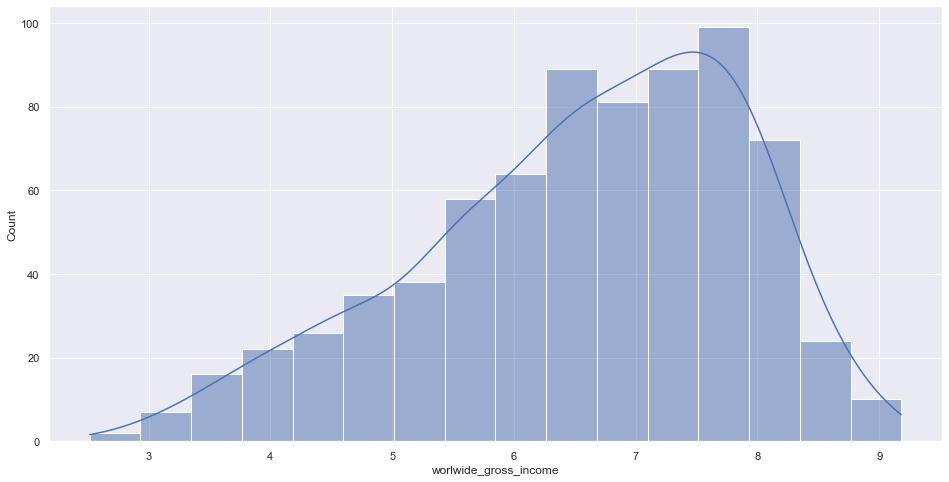

In [115]:
sns.set(rc={'figure.figsize':(16,8)})
sns.histplot(y, kde=True, edgecolor='w')

[Text(0.5, 0, 'income'), Text(0, 0.5, 'residuals')]

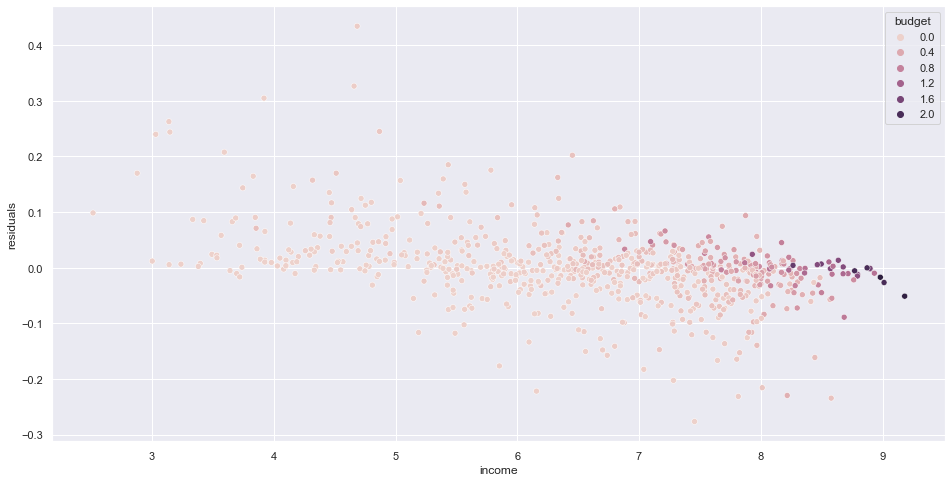

In [116]:
ax = sns.scatterplot(x=y,y=residuals, hue=df['budget'])
ax.set(xlabel='income', ylabel='residuals')

In [117]:
X_base = df[[
        'budget',
        'duration',
        'year',
        'date_published',
    ]]
y_base = df['worlwide_gross_income']
model_baseline = baseline.create_pipeline()

In [118]:
model_baseline = model_baseline.fit(X,y)

In [119]:
predict_y = model_baseline.predict(X)
residuals = predict_y - y

[Text(0.5, 0, 'income'), Text(0, 0.5, 'residuals')]

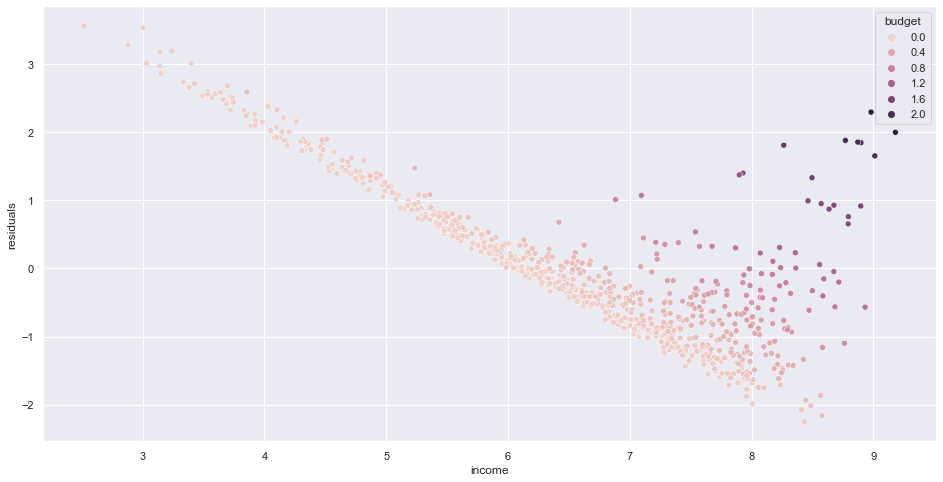

In [120]:
ax = sns.scatterplot(x=y,y=residuals, hue=df['budget'])
ax.set(xlabel='income', ylabel='residuals')

In [121]:
from CinePred import new_model
from CinePred.new_model import *

In [122]:
df = import_data('../raw_data/IMDb movies.csv')
df = df.sample(nbsample)
ohe = GenreOHE()
df = preproc(df)
ohe.fit(df)
df = ohe.transform(df)

df.sort_values('budget', inplace=True)
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)

mid = int(df.shape[0] / 2)
df1 = df.iloc[:mid]
df2 = df.iloc[mid:]

X1 = df1.drop(columns='worlwide_gross_income')
y1 = df1['worlwide_gross_income']

X2 = df2.drop(columns='worlwide_gross_income')
y2 = df2['worlwide_gross_income']

model1 = XGBRegressor().fit(X1, y1)
model2 = XGBRegressor().fit(X2, y2)

predict_y1 = model1.predict(X1)
predict_y2 = model2.predict(X2)

residuals1 = predict_y1 - y1
residuals2 = predict_y2 - y2

residuals = pd.concat([residuals1,residuals2])
y = pd.concat([y1,y2])


AttributeError: Can only use .str accessor with string values!

In [123]:
ax = sns.scatterplot(x=y,y=residuals, hue=df['budget'])
ax.set(xlabel='income', ylabel='residuals')

In [124]:
X1[X1['budget']==0]